In [1]:
%load_ext autoreload
%autoreload 2

import os, sys, time
import glob

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#needed to import utils.py
sys.path.append('../') 

import utils
import utils_preprocessing
import utils_exec_models
import utils_exec_models_new

import numpy as np
import pandas as pd
#to view entire text of the comuns
pd.set_option('display.max_colwidth', None) 

import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns


# Get all results CSV file

In [19]:
path = os.path.abspath('0_exec_results_py')


results_by_algorithm = []
algorithms = set()
scenarios = set()
features_configs = set()

for root, folders, files in os.walk(path, topdown=False):

    for name in files:
        if name.endswith('.csv'):

            aux = name.replace('.csv', '').replace('performance__','').split('__')
            algo = aux[0]
            feat = aux[1]
            scen = aux[2]
            es_algo = aux[3] if len(aux) == 4 else ''

            results_by_algorithm.append(
                [algo, feat, scen, es_algo, os.path.join(root, name)]
            )
            
            algorithms.add(algo)
            scenarios.add(scen)
            features_configs.add(feat)

print(algorithms, scenarios, features_configs)

{'RadiusNeighbors', 'MLP', 'SVC', 'DecisionTree', 'GaussianNB', 'KNeighbors', 'BalancedRandomForest', 'RandomForest', 'ComplementNB'} {'Ensemble_Imbalance', 'Single_Model'} {'All_Features', 'without_Diagnosis_Delay'}


# Get the performance for each $scenario$ and $features$

In [20]:
df_all = None

for algorithm, features, scenario, es_algorithm, csv_file in results_by_algorithm:
#     utils.print_string_with_separators(f'{scenario} - {features}')
    df_temp = utils.read_csv(csv_file=csv_file)

    #sort performances
    df_temp = utils_exec_models_new.sort_performances_results(df=df_temp)    

    # acumulate the performances
    if df_all is None:
        df_all = df_temp
    else:
        df_all = pd.concat([df_all, df_temp], ignore_index=True)

    
# df_all = utils_exec_models_new.sort_performances_results(df=df_all).reset_index(drop=True)    

display(df_all)

# utils.print_array_as_list(df_all.columns)

,Scenario,Features,Model,balanced_accuracy,sensitivity,specificity,f1_score,AUC,accuracy,precision,...,Estimator_Class,Estimator_Hyperparams,fit_time,train_balanced_accuracy,train_sensitivity,train_specificity,train_f1_score,train_AUC,train_accuracy,train_precision
0,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.85,0.87,0.82,0.54,0.88,0.82,0.39,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':7,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.75,0.66,0.84,0.49,0.84,0.82,0.39
1,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.85,0.87,0.82,0.54,0.88,0.82,0.39,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':7,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.75,0.66,0.84,0.49,0.84,0.82,0.39
2,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.84,0.89,0.79,0.52,0.89,0.80,0.36,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':5,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.77,0.70,0.83,0.49,0.85,0.81,0.38
3,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.84,0.89,0.79,0.52,0.89,0.80,0.36,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':5,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.77,0.70,0.83,0.49,0.85,0.81,0.38
4,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.84,0.89,0.79,0.52,0.89,0.80,0.37,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':5,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.76,0.70,0.83,0.49,0.85,0.81,0.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23645,Single_Model,All_Features,Naïve Bayes,0.63,0.28,0.99,0.41,0.88,0.90,0.76,...,NaN,NaN,0.01,0.60,0.22,0.99,0.33,0.86,0.89,0.73
23646,Single_Model,All_Features,Naïve Bayes,0.62,0.26,0.99,0.38,0.88,0.90,0.75,...,NaN,NaN,0.01,0.60,0.21,0.99,0.33,0.86,0.89,0.74
23647,Single_Model,All_Features,Naïve Bayes,0.62,0.26,0.99,0.38,0.88,0.90,0.75,...,NaN,NaN,0.01,0.60,0.21,0.99,0.33,0.86,0.89,0.74
23648,Single_Model,All_Features,Naïve Bayes,0.62,0.26,0.99,0.38,0.88,0.90,0.75,...,NaN,NaN,0.01,0.60,0.20,0.99,0.32,0.86,0.89,0.73


# Separate the performances into $balanced$ and $non\_balanced$ files and save them

In [21]:
models_balanced_param = {
        'DecisionTree': "'class_weight':'balanced'",
        'SVC': "'class_weight':'balanced'",
        'RandomForest': "'class_weight':'balanced" , # will serve to 'balanced' and 'balanced_subsample'
        'BalancedBaggingClassifier': "''class_weight':'balanced''"
    }


results_folder = '0_exec_results_py'
path = os.path.abspath(results_folder)


results_by_algorithm = []
algorithms = set()
scenarios = set()
features_configs = set()

for root, folders, files in os.walk(path, topdown=False):

    for name in files:
        if root.endswith(results_folder) and name.startswith('performance__') and name.endswith('.csv'):
#             print(root, folders, files)
            
            #
            aux = name.replace('.csv', '').replace('performance__','').split('__')
            algo = aux[0]
            feat = aux[1]
            scen = aux[2]
            es_algo = aux[3] if len(aux) == 4 else ''

#             if scen == 'Single_Model':
            if algo in models_balanced_param.keys():
                print(algo)
                df_aux = utils.read_csv(csv_file=os.path.join(root, name))

                # get models that used 'balanced' param 
                balanced_param = models_balanced_param[algo]

                # define wich column will be used to get hyperparams
                col_hyperparams = 'Hyperparams' if scen == 'Single_Model' else 'Estimator_Hyperparams'
                    

                # filter by hyperparams for non-Ensemble-Balance models
                df_bal = df_aux.loc[(df_aux[col_hyperparams].str.contains(balanced_param, regex=False))].copy()

                df_bal = utils_exec_models_new.sort_performances_results(df=df_bal)

                # get models that DONT used 'balanced' param 
                df_not_bal = df_aux.loc[(df_aux[col_hyperparams].str.contains(balanced_param, regex=False)==False)].copy()
                df_not_bal = utils_exec_models_new.sort_performances_results(df=df_not_bal)

                # save the separated results
                csv_to_save = f'{path}/separated_results/{algo}__{feat}__{scen}__{es_algo}__balanced.csv'
                utils.save_to_csv(df=df_bal, csv_file=csv_to_save)

                csv_to_save = f'{path}/separated_results/{algo}__{feat}__{scen}__{es_algo}__not_balanced.csv'
                utils.save_to_csv(df=df_not_bal, csv_file=csv_to_save)


RandomForest
64 samples were saved
32 samples were saved
DecisionTree
960 samples were saved
0 samples were saved
DecisionTree
16 samples were saved
16 samples were saved
DecisionTree
16 samples were saved
16 samples were saved
DecisionTree
960 samples were saved
0 samples were saved
SVC
32 samples were saved
32 samples were saved
RandomForest
64 samples were saved
32 samples were saved
SVC
960 samples were saved
0 samples were saved
SVC
960 samples were saved
0 samples were saved
SVC
32 samples were saved
32 samples were saved


In [22]:
df_all.fillna('', inplace=True)

df_all['Algorithm'] = df_all.Estimator_Class + ' ' + df_all.Model_Class    
df_all.Algorithm = df_all.Algorithm.str.replace('BalancedBagging', '').str.replace('Classifier', '').str.strip()

df_all.Algorithm = df_all.Algorithm.str.replace('BalancedRandomForest', 'RandomForest').str.strip()


df_all.sort_values(by=['Algorithm'], inplace=True)

df_all[['Algorithm', 'Estimator', 'Model', 'Model_Class', 'Estimator_Class']]

,Algorithm,Estimator,Model,Model_Class,Estimator_Class
23649,ComplementNB,,Naïve Bayes,ComplementNB,
14569,ComplementNB,Naïve Bayes,Balanced Bagging,BalancedBaggingClassifier,ComplementNB
14570,ComplementNB,Naïve Bayes,Balanced Bagging,BalancedBaggingClassifier,ComplementNB
14571,ComplementNB,Naïve Bayes,Balanced Bagging,BalancedBaggingClassifier,ComplementNB
14572,ComplementNB,Naïve Bayes,Balanced Bagging,BalancedBaggingClassifier,ComplementNB
...,...,...,...,...,...
3586,SVC,SVM,Balanced Bagging,BalancedBaggingClassifier,SVC
3585,SVC,SVM,Balanced Bagging,BalancedBaggingClassifier,SVC
3584,SVC,SVM,Balanced Bagging,BalancedBaggingClassifier,SVC
3591,SVC,SVM,Balanced Bagging,BalancedBaggingClassifier,SVC


# Plot 1

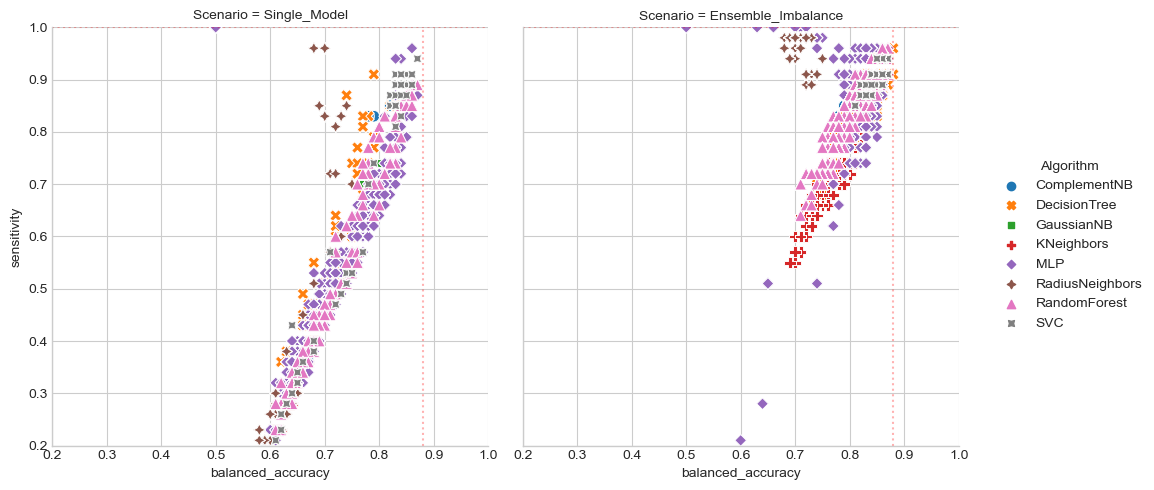

In [23]:
g = sns.relplot(
    data=df_all, 
    x="balanced_accuracy", 
    y="sensitivity",
    col="Scenario", 
    hue="Algorithm", 
    style="Algorithm",
    kind="scatter",
    s=70
)
plt.ylim(0.20, 1.0)
plt.xlim(0.20, 1.0)

g.refline(y=df_all.sensitivity.max(), linestyle=":", c='red', alpha=0.3, label='')
g.refline(x=df_all.balanced_accuracy.max(), linestyle=":", c='red', alpha=0.3)


# Plot 2

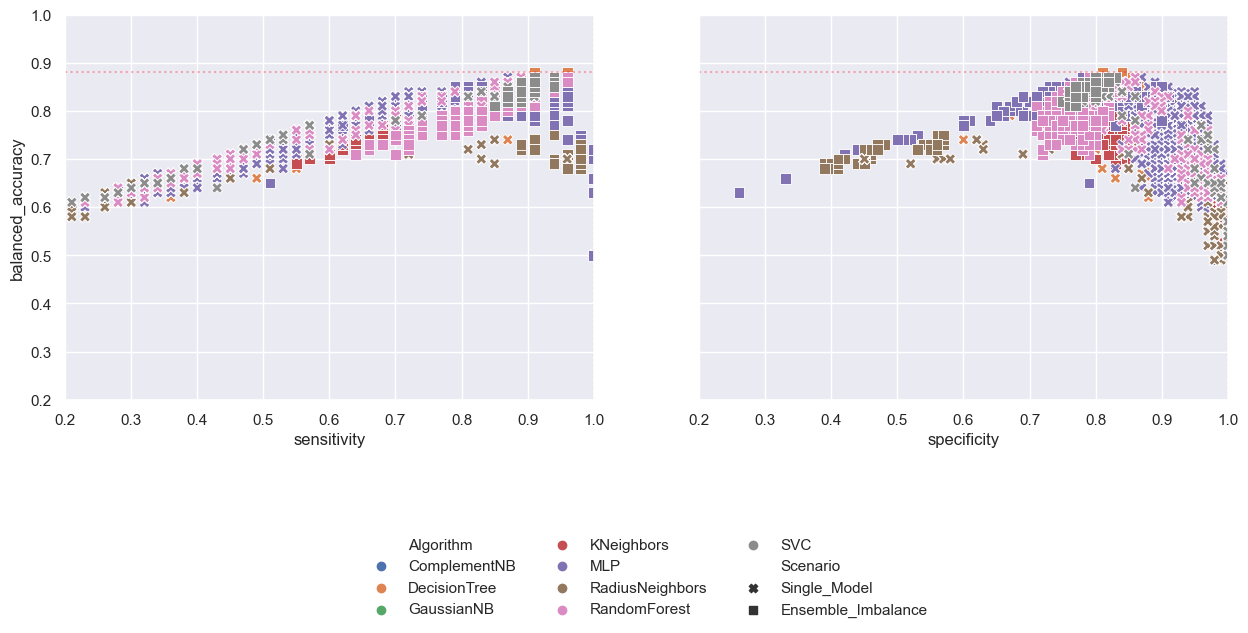

In [103]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharey=True)

g = sns.scatterplot(
    ax=axs[0],
    data=df_all, 
    x="sensitivity", 
    y="balanced_accuracy", 
    hue="Algorithm", 
    style="Scenario",
    markers={"Single_Model": "X", "Ensemble_Imbalance": "s"},
    s=60,
    legend=False,
)
axs[0].set_ylim(0.2, 1.0)
axs[0].set_xlim(0.2, 1.0)

axs[0].axvline(x=df_all.sensitivity.max(), linestyle=":", c='red', alpha=0.3)
axs[0].axhline(y=df_all.balanced_accuracy.max(), linestyle=":", c='red', alpha=0.3)


sns.scatterplot(
    ax=axs[1],
    data=df_all, 
    x="specificity", 
    y="balanced_accuracy", 
    hue="Algorithm", 
    style="Scenario",
    markers={"Single_Model": "X", "Ensemble_Imbalance": "s"},
    s=60,
)
axs[1].set_ylim(0.2, 1.0)
axs[1].set_xlim(0.2, 1.0)

axs[1].axvline(x=df_all.specificity.max(), linestyle=":", c='red', alpha=0.3)
axs[1].axhline(y=df_all.balanced_accuracy.max(), linestyle=":", c='red', alpha=0.3)

plt.legend(loc='lower center', bbox_to_anchor=(-0.1, -0.6), ncol=3)


# Plot by algorithm 

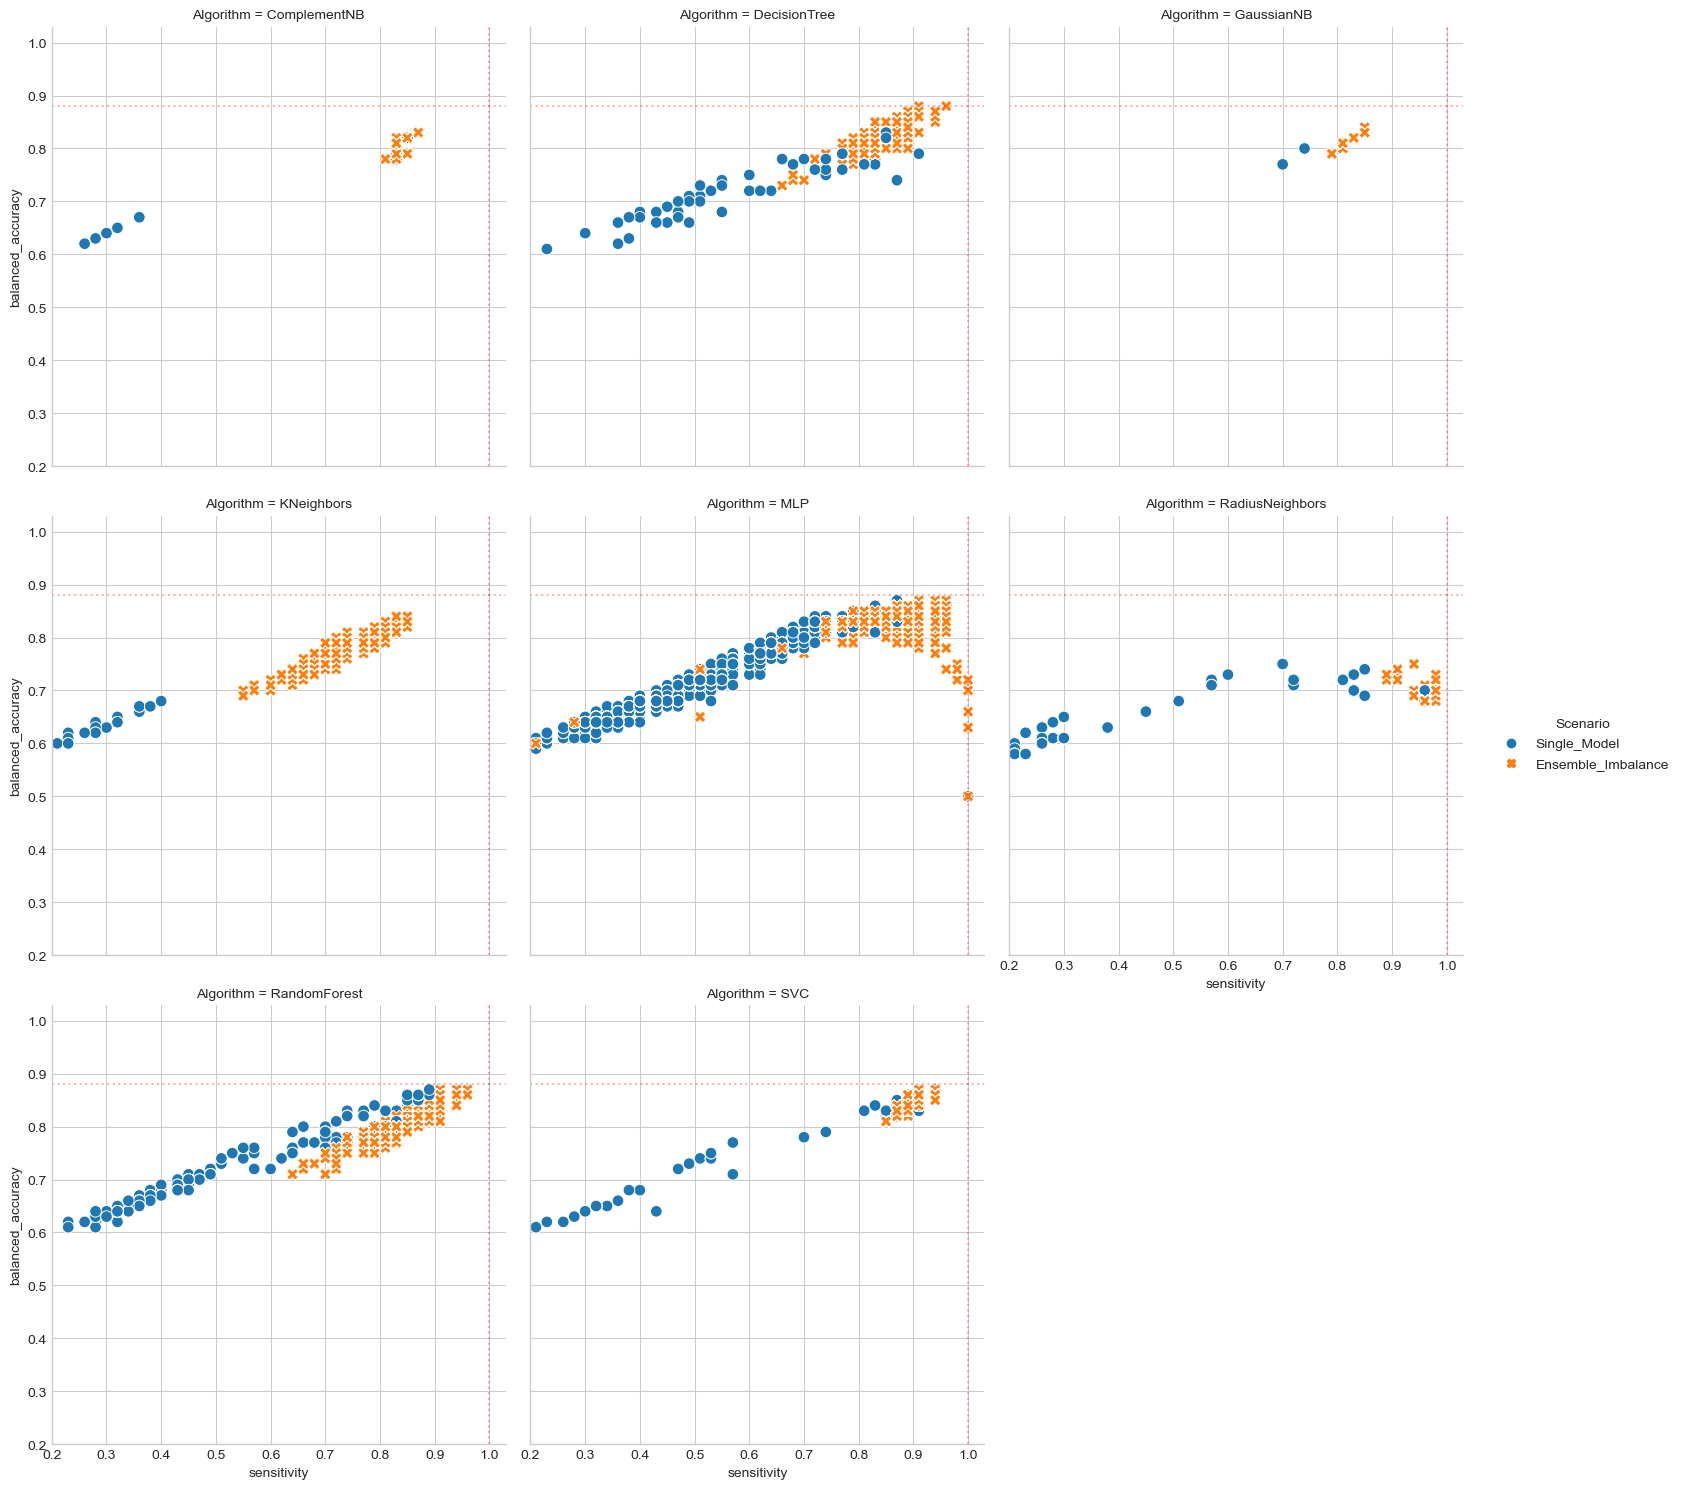

In [30]:
g = sns.relplot(
    data=df_all, 
    y="balanced_accuracy", 
    x="sensitivity",
    hue="Scenario", 
    col="Algorithm", 
    style="Scenario",
    kind="scatter",
    s=70,
    col_wrap=3,
)
plt.ylim(0.20, 1.03)
plt.xlim(0.20, 1.03)

g.refline(x=df_all.sensitivity.max(), linestyle=":", c='red', alpha=0.3, label='')
g.refline(y=df_all.balanced_accuracy.max(), linestyle=":", c='red', alpha=0.3)


# Plot by algorithm using only the best performance for each scenario 

In [124]:
df_aux = df_all.copy()

df_aux['Scenario_Features'] = df_aux.Scenario + ' / '+ df_aux.Features

df_aux = df_aux.sort_values(by=['Algorithm','Scenario_Features','balanced_accuracy','sensitivity','specificity'], 
                            ascending=[True, True, False, False, False]).reset_index().copy()

df_aux = df_aux.groupby(by=['Algorithm','Scenario_Features']).first().reset_index()

    
df_aux = utils_exec_models_new.sort_performances_results(df=df_aux).drop(columns=['index'])

df_aux

,Algorithm,Scenario_Features,Scenario,Features,Model,balanced_accuracy,sensitivity,specificity,f1_score,AUC,...,Estimator_Class,Estimator_Hyperparams,fit_time,train_balanced_accuracy,train_sensitivity,train_specificity,train_f1_score,train_AUC,train_accuracy,train_precision
4,DecisionTree,Ensemble_Imbalance / All_Features,Ensemble_Imbalance,All_Features,Balanced Bagging,0.88,0.96,0.81,0.57,0.94,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'gini','max_depth':4,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.80,0.74,0.85,0.54,0.89,0.84,0.43
24,RandomForest,Ensemble_Imbalance / All_Features,Ensemble_Imbalance,All_Features,Balanced Random Forest,0.87,0.96,0.79,0.55,0.93,...,,,0.01,0.81,0.81,0.81,0.53,0.89,0.81,0.40
16,MLP,Ensemble_Imbalance / All_Features,Ensemble_Imbalance,All_Features,Balanced Bagging,0.87,0.96,0.79,0.55,0.94,...,MLPClassifier,"{'activation':'tanh','alpha':0.1,'batch_size':'auto','beta_1':0.9,'beta_2':0.999,'early_stopping':False,'epsilon':1e-08,'hidden_layer_sizes':30,'learning_rate':'adaptive','learning_rate_init':0.7,'max_fun':15000,'max_iter':2000,'momentum':0.9,'n_iter_no_change':10,'nesterovs_momentum':True,'power_t':0.5,'random_state':42,'shuffle':True,'solver':'adam','tol':0.0001,'validation_fraction':0.1,'verbose':False,'warm_start':False}",0.02,0.83,0.81,0.85,0.58,0.91,0.85,0.45
28,SVC,Ensemble_Imbalance / All_Features,Ensemble_Imbalance,All_Features,Balanced Bagging,0.87,0.94,0.81,0.56,0.93,...,SVC,"{'C':3,'break_ties':False,'cache_size':200,'class_weight':'balanced','coef0':0.0,'decision_function_shape':'ovr','degree':3,'gamma':'auto','kernel':'rbf','max_iter':-1,'probability':True,'random_state':42,'shrinking':True,'tol':0.001,'verbose':False}",0.39,0.83,0.81,0.85,0.58,0.91,0.84,0.45
17,MLP,Ensemble_Imbalance / without_Diagnosis_Delay,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.87,0.94,0.80,0.54,0.88,...,MLPClassifier,"{'activation':'relu','alpha':0.1,'batch_size':'auto','beta_1':0.9,'beta_2':0.999,'early_stopping':False,'epsilon':1e-08,'hidden_layer_sizes':(22,),'learning_rate':'constant','learning_rate_init':0.3,'max_fun':15000,'max_iter':2000,'momentum':0.9,'n_iter_no_change':10,'nesterovs_momentum':True,'power_t':0.5,'random_state':42,'shuffle':True,'solver':'adam','tol':0.0001,'validation_fraction':0.1,'verbose':False,'warm_start':False}",0.01,0.79,0.74,0.83,0.52,0.86,0.82,0.40
30,SVC,Single_Model / All_Features,Single_Model,All_Features,SVM,0.87,0.94,0.80,0.54,0.93,...,,,0.06,0.82,0.80,0.84,0.56,0.90,0.84,0.43
26,RandomForest,Single_Model / All_Features,Single_Model,All_Features,Random Forest,0.87,0.89,0.86,0.60,0.92,...,,,0.02,0.80,0.73,0.88,0.57,0.90,0.86,0.48
18,MLP,Single_Model / All_Features,Single_Model,All_Features,Neural Networks,0.87,0.87,0.87,0.61,0.94,...,,,0.01,0.50,0.17,0.83,0.04,0.41,0.75,0.02
29,SVC,Ensemble_Imbalance / without_Diagnosis_Delay,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.85,0.91,0.79,0.53,0.89,...,SVC,"{'C':0.5,'break_ties':False,'cache_size':200,'class_weight':'balanced','coef0':0.0,'decision_function_shape':'ovr','degree':3,'gamma':'auto','kernel':'linear','max_iter':-1,'probability':True,'random_state':42,'shrinking':True,'tol':0.001,'verbose':False}",0.14,0.79,0.77,0.82,0.51,0.86,0.81,0.39
5,DecisionTree,Ensemble_Imbalance / without_Diagnosis_Delay,Ensemble_Imbalance,without_Diagnosis_Delay,Balanced Bagging,0.85,0.87,0.82,0.54,0.88,...,DecisionTreeClassifier,"{'ccp_alpha':0.0,'class_weight':'balanced','criterion':'entropy','max_depth':7,'max_features':None,'max_leaf_nodes':None,'min_impurity_decrease':0.0,'min_samples_leaf':1,'min_samples_split':2,'min_weight_fraction_leaf':0.0,'random_state':42,'splitter':'best'}",0.01,0.75,0.66,0.84,0.49,0.84,0.82,0.39


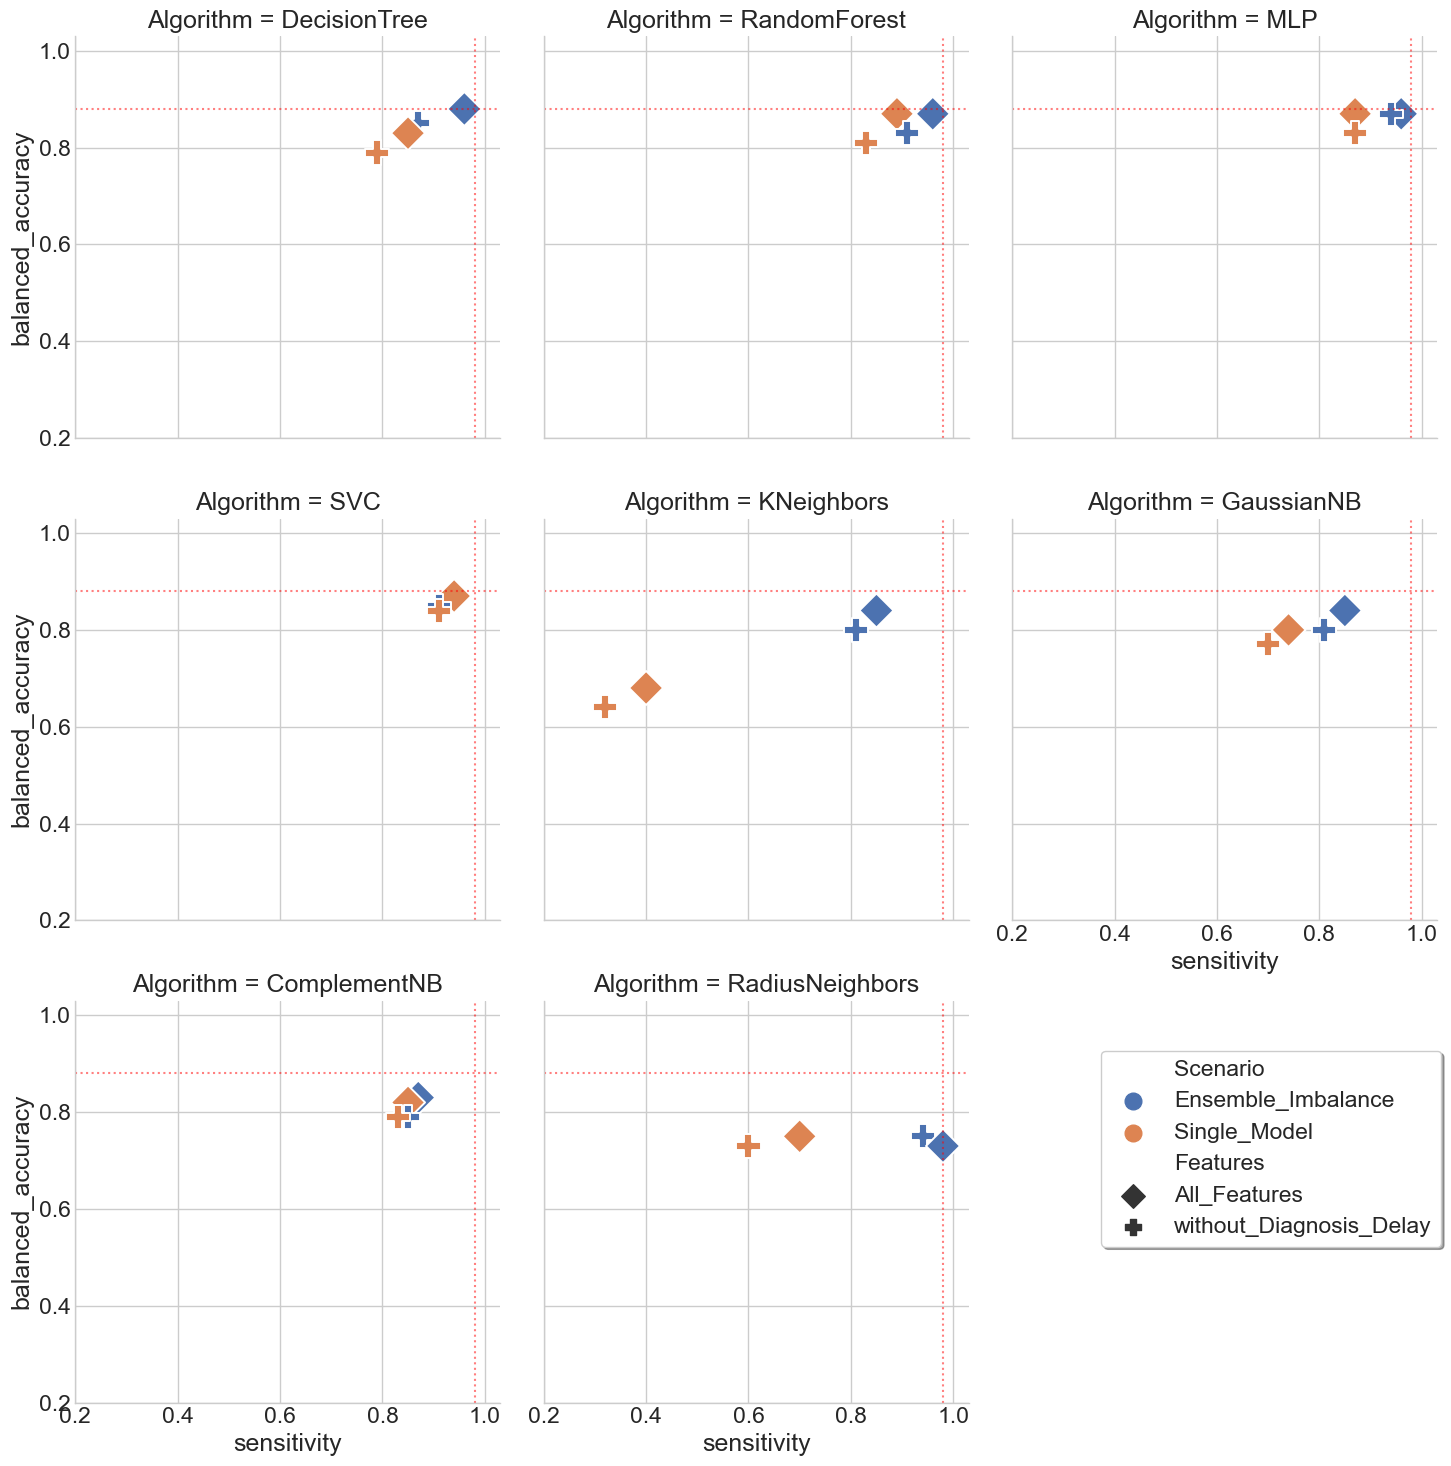

In [137]:
sns.set(font_scale=1.5)

try:
    plt.style.use('seaborn-whitegrid')
except:
    plt.style.use('seaborn-v0_8-whitegrid')
    
    
g = sns.relplot(
    data=df_aux, 
    y="balanced_accuracy", 
    x="sensitivity",
    col="Algorithm",
    #
#     hue="Features", 
#     style="Scenario",
#     markers={"Single_Model": "X", "Ensemble_Imbalance": "D"},
    #
    hue="Scenario", 
    style="Features",
    markers={"All_Features": "D", "without_Diagnosis_Delay": "P"},
    #
    kind="scatter",
    s=300,
    col_wrap=3,
)
plt.ylim(0.2, 1.03)
plt.xlim(0.2, 1.03)

g.refline(x=df_aux.sensitivity.max(), linestyle=":", c='red', alpha=0.5, label='')
g.refline(y=df_aux.balanced_accuracy.max(), linestyle=":", c='red', alpha=0.5)

sns.move_legend(
    g, 
    "lower center", 
    bbox_to_anchor=(0.7, 0.15), 
    frameon=True, 
    shadow=True,
    markerscale=2,
)

plt.show()

sns.set(font_scale=1)
